# Sleep Wake Dynamics  Prior and After Exposure to Chronic Stress

# Abstract

We showed in our previous publication how sleep disturbances prior to exposure to chronic stress can predict the vulnerability to stress.  The following evidence was extracted from our data:

(a) Decrease in NREM average bout duration in Stress-Susceptible mice pre- and post-chronic stress

(b) Increase in number of transitions between NREM and Wake states in Stress-Susceptible mice pre- and post-chronic stress. (a) & (b) can be summarized as increased NREM sleep fragmentation in susceptible mice.

(c) Increase in number of transitions between NREM and Wake states and decreased average bout duration of NREM in resilient mice post exposure to stress

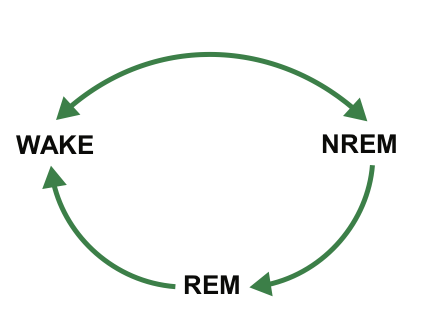

# Aim of the current investigation
By leveraging the statistical properties of the sleep and wake bouts distribution (exponential and power law respectively) and by stratifying the bouts based on their transitions, one could gain valuable insights into the network properties and dynamics in order to plan the next step of neural circuit-based investigation. 

# The state transitions we are focusing on:

1. NREM to Wake
2. NREM to REM

3. REM from NREM

4. Wake from NREM
5. Wake from REM

Other state transitions are rare and can be safely ignored in our analysis.

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import glob
import os

from sklearn import linear_model
from lifelines import KaplanMeierFitter

os.chdir('/Users/bmr225/Documents/PythonCodes/Survival_Data')

In [5]:
%matplotlib inline
#mpl.rcParams['figure.figsize'] = 8,8 # to fix the figure size
#matplotlib.rcParams['figure.dpi'] = 64
sns.set_style('whitegrid') 
# Default settings
mpl.rcParams['image.cmap'] = 'jet'
sns.set()

In [9]:
# List of functions used to plot the distributions
def load_data(phenotype,phase,condition):
    df = pd.read_csv(phenotype + "_"+ phase + "_" + condition + "_grouped.csv")
    return df

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def grouping_data(df,direction,measure):
    if direction == 'To':
       df_res = df.groupby(['State_Label','Transition_to_label'])[measure].apply(list)
    elif direction =='From':
        df_res = df.groupby(['State_Label','Transition_from_label'])[measure].apply(list)
    else:
        df_res = df.groupby('State_Label')[measure].apply(list)
    return df_res

#Transition To: N-W, N-R, R-W, W-R... , from: WfN, WfR, NfR, NfW, 
def extract_list(df,state,transition): # df here is grouped.. 
    if transition =='None':
       l_res = df[state]
    else:
       l_res = df[state][transition]
    return l_res

######################################################################################################################
# Plotting functions

# Plotting ECDF
def plt_phenotypes_per_phase_cond(phenotype,phase, condition,state, direction, transition,measure):   
    # load, group, extract the list of interest
    df = load_data(phenotype,phase,condition)    
    df_grouped = grouping_data(df,direction,measure) 
    l_ = extract_list(df_grouped,state,transition) 
    X,Y = ecdf(l_)   
    # plot command
    _ = plt.xlabel('Duration [s]')
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.plot(X,Y,marker='.',linestyle = 'none',label = phenotype)

    
# Plotting Distribution PDF:
def plt_distribution_phenotypes_per_phase_cond(phenotype,phase, condition,state, direction, transition,measure):   
    # load, group, extract the list of interest
    df = load_data(phenotype,phase,condition)    
    df_grouped = grouping_data(df,direction,measure) 
    l_ = extract_list(df_grouped,state,transition) 
    sns.distplot(l_,label = phenotype)   
    # plot command
    _ = plt.xlabel('Duration [s]')
    _ = plt.ylabel('Probability')
    #_ = plt.plot(X,Y,marker='.',linestyle = 'none',label = phenotype)

    
    
# to loop over the 3 phenotypes
def plt_loop_over_phenotype(phase, condition,state, direction, transition,measure):
    for phenotype in ['Susceptible','Resilient','Control']:
        plt_phenotypes_per_phase_cond(phenotype,phase,condition,state, direction, transition,measure)
        plt.title(condition + "-" + "-" + phase + "-"+ transition)
        plt.legend(loc = 'lower right')
    #plt.show()
    
# to loop over the 3 phenotypes_ plot distribution
def plt_loop_over_phenotype_dist(phase, condition,state, direction, transition,measure):
    for phenotype in ['Susceptible','Resilient','Control']:
        plt_distribution_phenotypes_per_phase_cond(phenotype,phase,condition,state, direction, transition,measure)
        plt.title(condition + "-" + "-" + phase + "-"+ transition)
        plt.legend(loc = 'lower right')
        plt.xlim((0,500))
     

In [10]:
# Statistical Analyses
def list_phenotypes_per_phase_cond(phenotype,phase, condition,state, direction, transition,measure):   
    # load, group, extract the list of interest
        df = load_data(phenotype,phase,condition)    
        df_grouped = grouping_data(df,direction,measure) 
        l_ = extract_list(df_grouped,state,transition) 
        return l_

# Plotting Cumulative Distribution Function of Vigilance States

### REM states transitioning from NREM ( The vast majority of REM states)

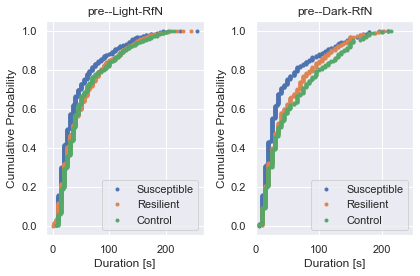

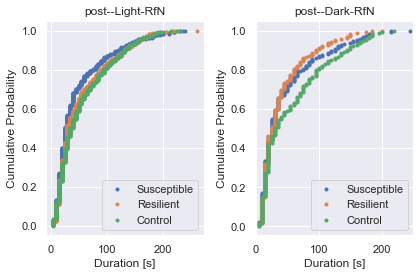

In [7]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'From'
state = 'REM'
transition = 'RfN'
measure = 'Duration'

for c in condition:
    i = 1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout()  
    plt.xlim([0,250])
    plt.show()      

### Statistical Tests: Kolmogorov-Smirnov Test

In [11]:
#Statistical Testing
from scipy.stats import ks_2samp
# Light Pre
##########
p = 'Light'
c ='pre'
direction = 'From'
s = 'REM'
transition = 'RfN'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))


Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.10894608693353948, pvalue=0.0027569102025022385)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.05862433204921089, pvalue=0.3033370018753667)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.13883645325363117, pvalue=0.00017100913673062657)


In [13]:
#Statistical Testing
from scipy.stats import ks_2samp
# Dark Pre
##########
p = 'Dark'
c ='pre'
direction = 'From'
s = 'REM'
transition = 'RfN'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))



Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.15443817692612372, pvalue=0.00019365633326917653)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.060984484615608535, pvalue=0.5630373179033593)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.17604161679991065, pvalue=3.338157172405598e-05)


In [14]:
#Statistical Testing
from scipy.stats import ks_2samp

# Light Post
###########

p = 'Light'
c ='post'
direction = 'From'
s = 'REM'
transition = 'RfN'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.09222723393880287, pvalue=0.007881593793397701)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.05993907083015994, pvalue=0.2461032443966652)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.13690354772402755, pvalue=4.628879958101795e-05)


In [15]:
#Statistical Testing
from scipy.stats import ks_2samp
# Dark Post
#########
p = 'Dark'
c ='post'
direction = 'From'
s = 'REM'
transition = 'RfN'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))


Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.05423524688879968, pvalue=0.8736085196834112)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.1718289889846221, pvalue=0.006120081653276377)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.13589964334030255, pvalue=0.04470934559696771)


#### NREM states transitioning to Wake

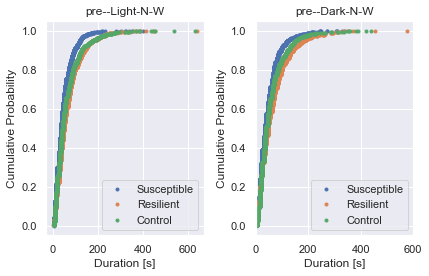

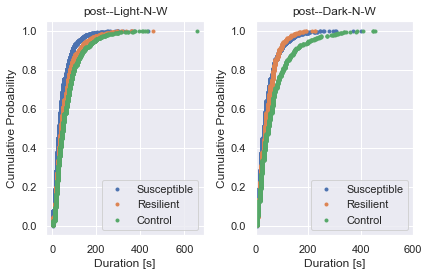

In [23]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'To'
state = 'NREM'
transition = 'N-W'
measure = 'Duration'

for c in condition:
    i = 1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout() 
    plt.xlim([0,600])
    plt.show()      

#### Kolmogorov-Smirnov Statistical Test 

In [17]:
#Statistical Testing
from scipy.stats import ks_2samp
# Light Pre
##########
p = 'Light'
c ='pre'
direction = 'To'
s = 'NREM'
transition = 'N-W'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.15196192851743504, pvalue=4.52049508936625e-12)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.05947419646441454, pvalue=0.005244099931707602)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.10130828655097326, pvalue=6.723638534822385e-09)


In [19]:
#Statistical Testing
from scipy.stats import ks_2samp
# Light Pre
##########
p = 'Dark'
c ='pre'
direction = 'To'
s = 'NREM'
transition = 'N-W'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))


Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.13724721447592475, pvalue=6.327605106548617e-12)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.07404655931283835, pvalue=0.00224685845170014)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.07342999617160885, pvalue=0.00022175597885731868)


In [20]:
#Statistical Testing
from scipy.stats import ks_2samp
# Light Post
##########
p = 'Light'
c ='post'
direction = 'To'
s = 'NREM'
transition = 'N-W'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.11884056267247446, pvalue=1.5731936831020477e-07)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.08367622202113674, pvalue=1.887031243363868e-05)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.20138586443555206, pvalue=1.1888904416501589e-08)


In [22]:
#Statistical Testing
from scipy.stats import ks_2samp
# Dark post
##########
p = 'Dark'
c ='post'
direction = 'To'
s = 'NREM'
transition = 'N-W'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.07224638001601784, pvalue=0.0013188967275140628)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.14572649337247967, pvalue=4.215290339004696e-10)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.17816797098237716, pvalue=5.551115123125783e-16)


#### NREM states transitioning to REM

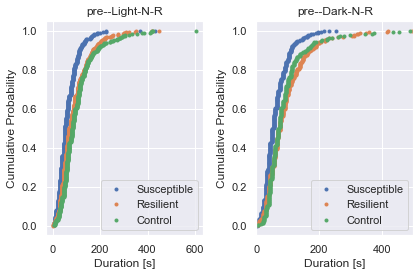

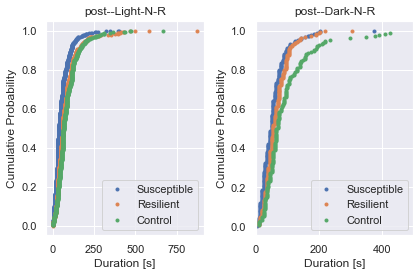

In [25]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'To'
state = 'NREM'
transition = 'N-R'
measure = 'Duration'

for c in condition:
    i = 1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout() 
    plt.xlim([0,500])
    plt.show()      

#### Kolmogorov-Smirnov Statistical Test 

In [26]:
#Statistical Testing
from scipy.stats import ks_2samp
# Light Pre
##########
p = 'Light'
c ='pre'
direction = 'To'
s = 'NREM'
transition = 'N-R'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.19180616536335734, pvalue=2.834208645552394e-09)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.09983706833464508, pvalue=0.008990730314495043)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.28884169681715693, pvalue=3.3306690738754696e-16)


In [39]:
#Statistical Testing
from scipy.stats import ks_2samp
# Dark Pre
##########
p = 'Dark'
c ='pre'
direction = 'To'
s = 'NREM'
transition = 'N-R'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.22052938525205895, pvalue=1.3123148345783875e-08)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.07229839218311841, pvalue=0.3506028719774662)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.21618236073212377, pvalue=1.2557355366649148e-07)


In [40]:
#Statistical Testing
from scipy.stats import ks_2samp
# Light Post
##########
p = 'Light'
c ='post'
direction = 'To'
s = 'NREM'
transition = 'N-R'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.23849323418261612, pvalue=9.992007221626409e-16)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.07303884234577304, pvalue=0.09050802600209751)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.3071848864759693, pvalue=3.3306690738754696e-16)


In [41]:
#Statistical Testing
from scipy.stats import ks_2samp
# Dark Post
##########
p = 'Dark'
c ='post'
direction = 'To'
s = 'NREM'
transition = 'N-R'
measure = 'Duration'

l_Susceptible = list_phenotypes_per_phase_cond(phenotype ='Susceptible', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Resilient = list_phenotypes_per_phase_cond(phenotype ='Resilient', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)
l_Control = list_phenotypes_per_phase_cond(phenotype ='Control', phase=p, condition = c,state = s, direction=direction, transition=transition,measure=measure)

print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) {}'.format(ks_2samp(l_Susceptible, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) {}'.format(ks_2samp(l_Control, l_Resilient)))
print('Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) {}'.format(ks_2samp(l_Susceptible, l_Control)))

Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Resilient)) Ks_2sampResult(statistic=0.1488759534323565, pvalue=0.012410860461199769)
Kolmogorov-Smirnov test between ks_2samp(l_Control, l_Resilient)) Ks_2sampResult(statistic=0.1599956374740975, pvalue=0.01312898579263877)
Kolmogorov-Smirnov test between ks_2samp(l_Susceptible, l_Control)) Ks_2sampResult(statistic=0.2610503013159513, pvalue=1.7849454172491619e-06)


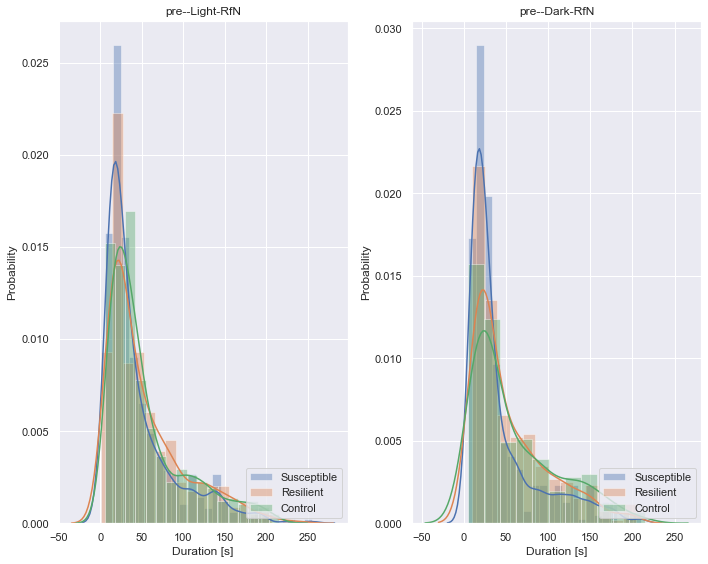

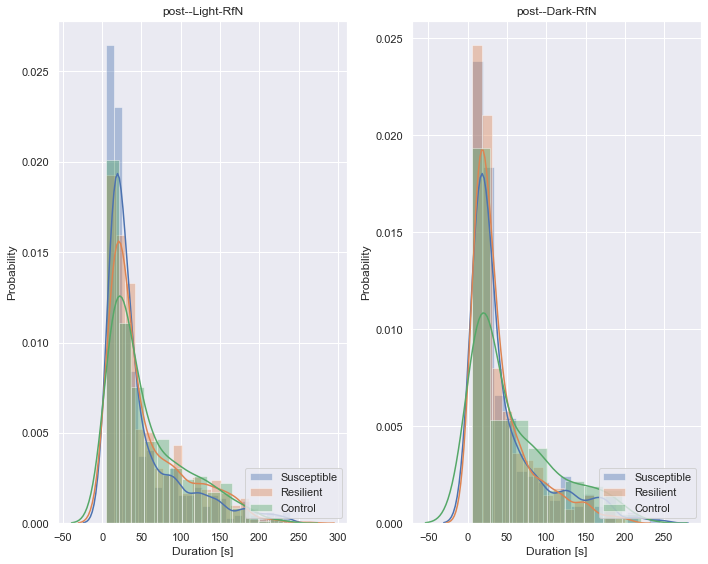

In [107]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'From'
state = 'REM'
transition = 'RfN'
measure = 'Duration'

for c in condition:
    i=1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype_dist(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout()    
    plt.show()          

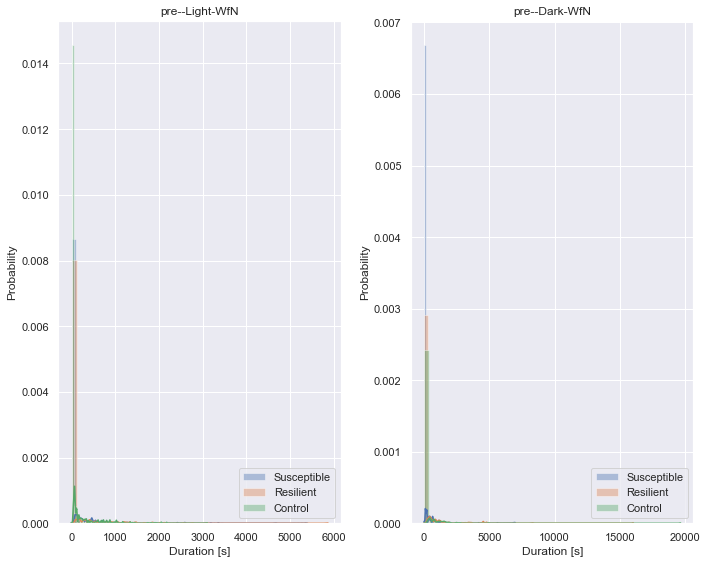

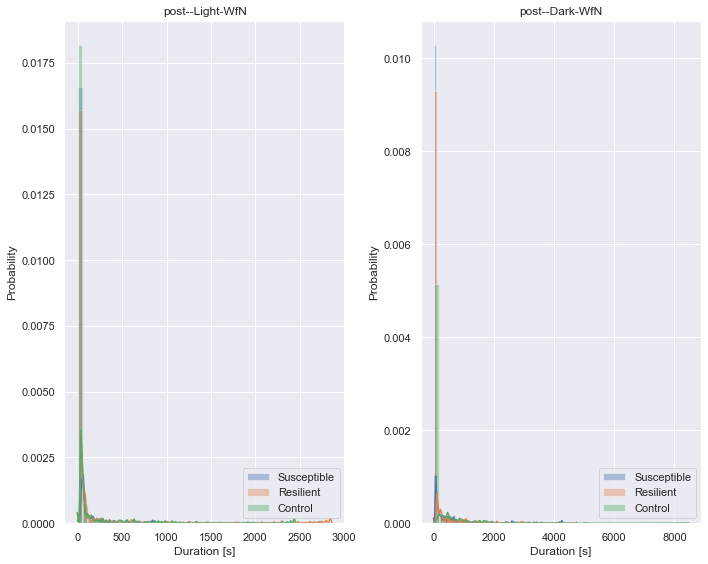

In [108]:
# Power law distribtion of Wake bouts
phase = ['Light','Dark']
condition =['pre','post']
direction = 'From'
state = 'Wake'
transition = 'WfN'
measure = 'Duration'

for c in condition:
    i=1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype_dist(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout()    
    plt.show()          

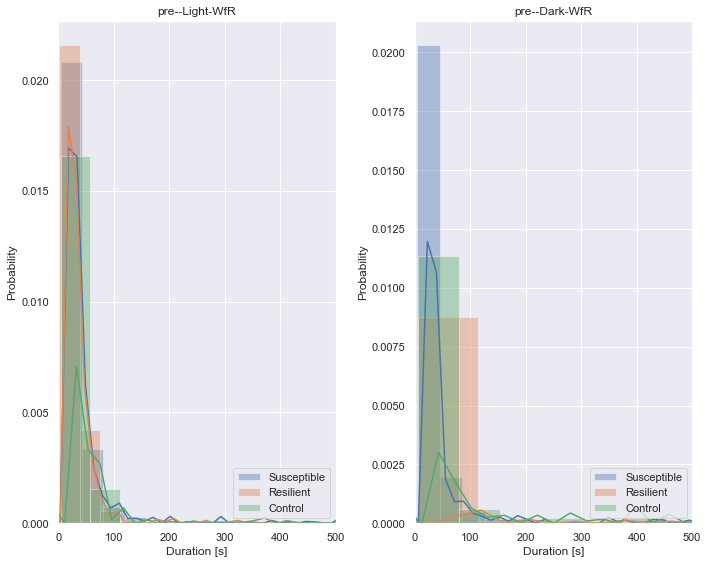

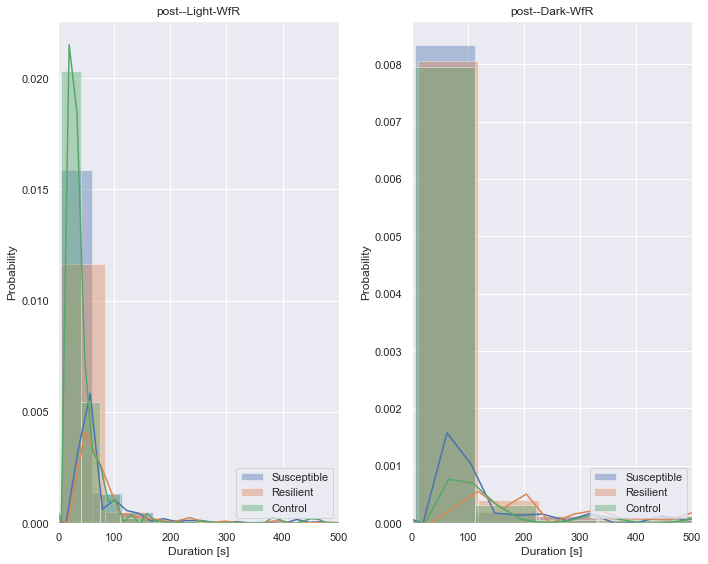

In [113]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'From'
state = 'Wake'
transition = 'WfR'
measure = 'Duration'

for c in condition:
    i=1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype_dist(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout()    
    plt.show()          

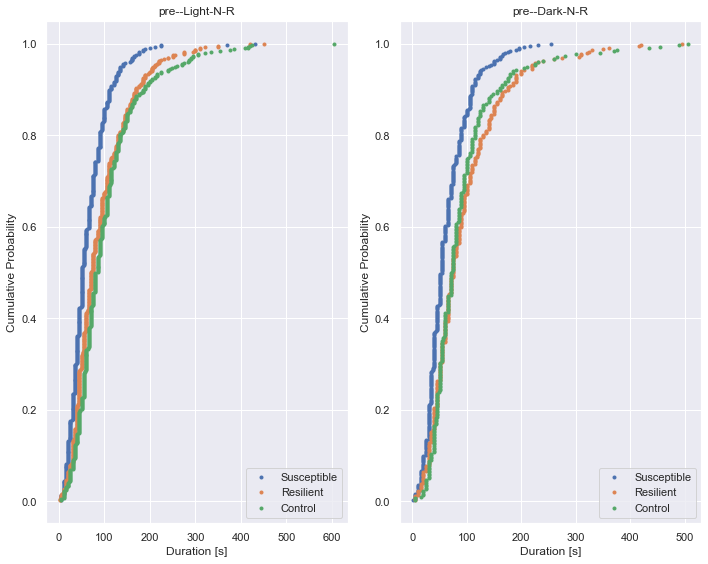

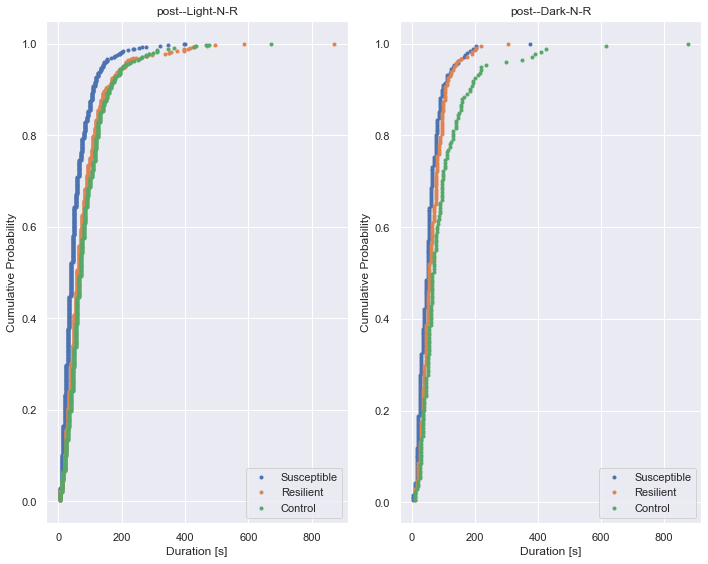

In [99]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'To'
state = 'NREM'
transition = 'N-R'
measure = 'Duration'

for c in condition:
    i = 1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype(p, c,state, direction, transition,measure)
        i+=1
    plt.tight_layout()    
    plt.show()      

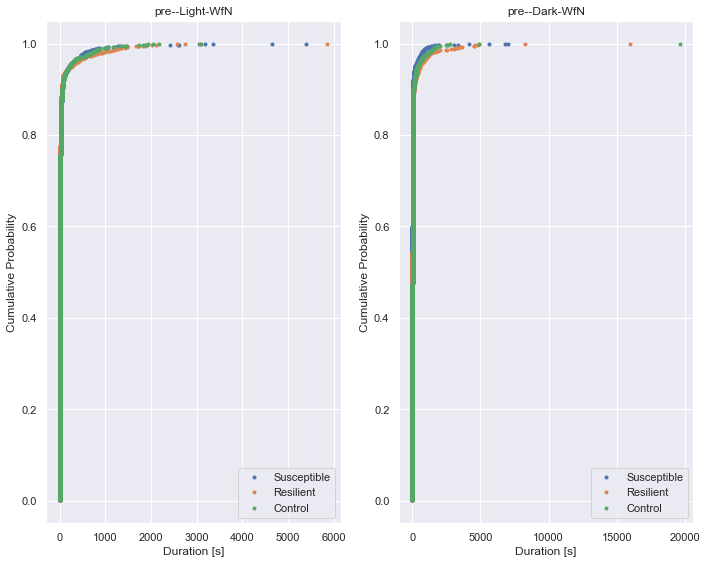

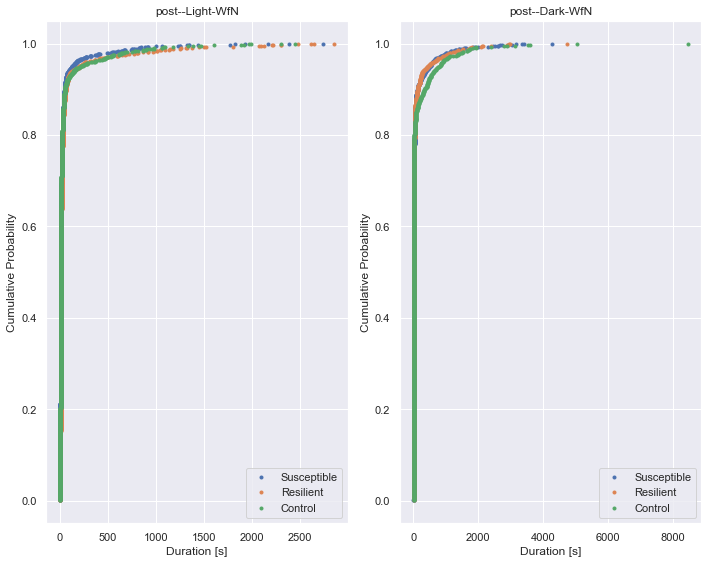

In [102]:
phase = ['Light','Dark']
condition =['pre','post']
direction = 'From'
state = 'Wake'
transition = 'WfN'
measure = 'Duration'

for c in condition:
    i = 1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype(p, c,state, direction, transition,measure)
        i+=1
    
    plt.tight_layout()    
    plt.show()        
        

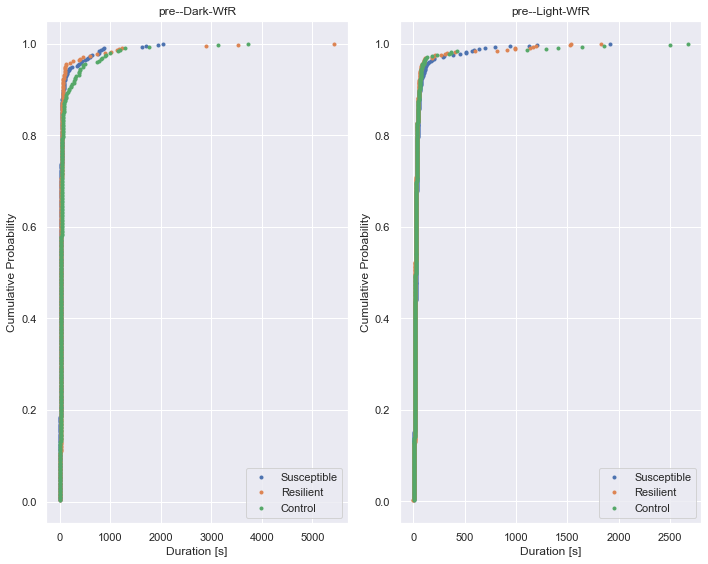

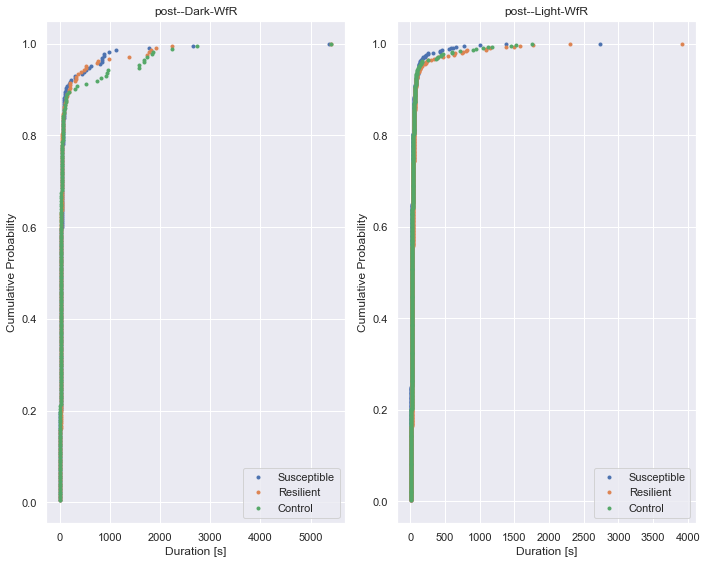

In [101]:
phase = ['Dark','Light']
condition =['pre','post']
direction = 'From'
state = 'Wake'
transition = 'WfR'
measure = 'Duration'


for c in condition:
    i = 1
    for p in phase:
        _ = plt.subplot(1,2,i) 
        plt_loop_over_phenotype(p, c,state, direction, transition,measure)
        i+=1
        
    plt.tight_layout()    
    plt.show()        
               
        

# Non parametric statistical Testing
Still need to perform non parametric statistical test comparisons between the distributions across the phenotypes using Kolmogorov-Smirnov test 

# % Duration, Count of states 

In [63]:
# Loading data frame of count, % count, total duration, % total duration of state transitions per mouse per phenotype per condition per phase
df_res = pd.read_csv('count+Dur_stateTransitions_0424.csv')


By plotting the cumulative distribution function of the following states: (1) NREM to Wake (2) NREM to REM (3) REM from NREM (4) Wake from NREM (5) Wake from REM, the following observations are made:
- Susceptible Mice: the distribution of state "NREM" to REM and "REM" from NREM are shifted to the left: higher probability of shorter state duration, pre- and post- stress during light and dark in comparison to control and/or resilient
- Susceptible Mice : the distribution of state "NREM" to wake is shifted to the left as well: higher probability of shorter state duration, pre-and post stress, during light and dark in comparison to one or both other phenotypes
- Resilient Mice: post chronic stress, during the light, only "NREM" to wake distribution shifted slightly to the left, or towards higher probability of shorter bouts duration. Both "NREM" to REM and "REM" to wake distribution were "resilient" post stress exposure. In other words, they remain shifted to the right relative to the distribution of the susceptible and similar to the distribution of stress-naive(control) mice. During the dark, however, the picture changed: the distribution of "NREM" to wake, "NREM" to REM and "REM" to wake shifted to the left, similar to the susceptible mice. 
- The distribution of the wake states, "Wake" from REM and "Wake" from NREM is comparable among all phenotypes.

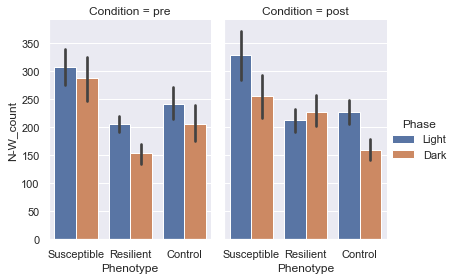

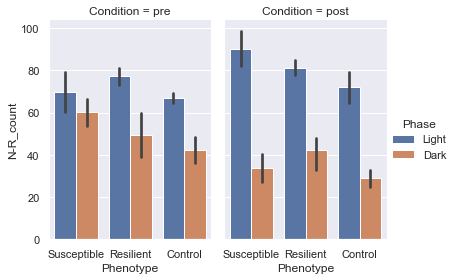

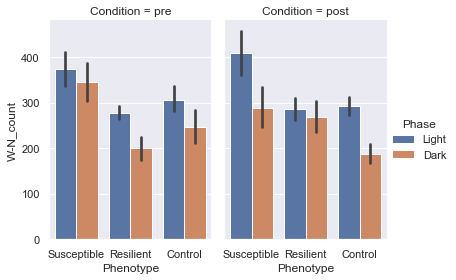

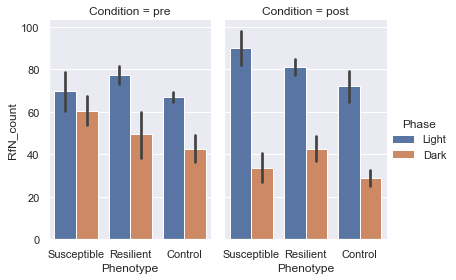

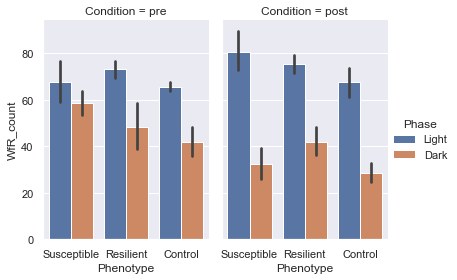

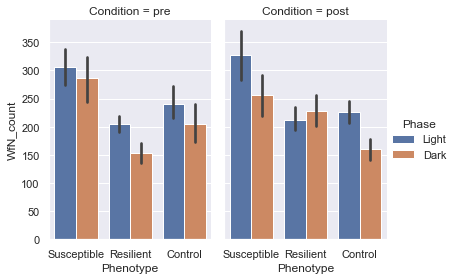

In [64]:
Trans_state =[ 'N-W_count','N-R_count','W-N_count','RfN_count','WfR_count','WfN_count']

for trans in Trans_state:
    g = sns.catplot(x='Phenotype',y = trans,
                hue = 'Phase', col = 'Condition',
                data = df_res, kind ="bar",
                height = 4, aspect = .7, ci =68) # standard error ci = 68 .. before it was showing standard deviation
    

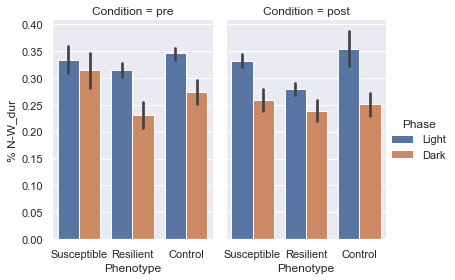

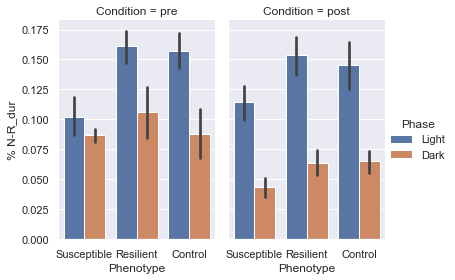

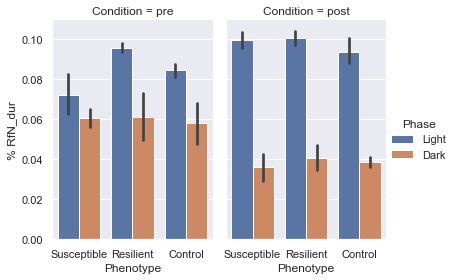

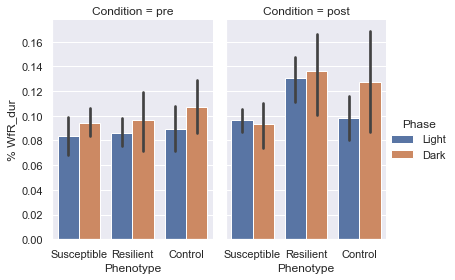

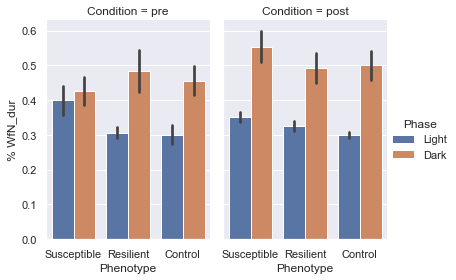

In [65]:
Trans_state =['% N-W_dur','% N-R_dur','% RfN_dur','% WfR_dur','% WfN_dur']
for trans in Trans_state:
    g = sns.catplot(x='Phenotype',y = trans,
                hue = 'Phase', col = 'Condition',
                data = df_res, kind ="bar",
                height = 4, aspect = .7, ci =68) # standard error ci = 68 .. before it was showing standard deviation
    

In [66]:
# Grouping by Phenotype
df_res_group = df_res.groupby(['Phenotype','Condition','Phase'])[['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']].mean()
df_res_group

% N-W_dur  % N-R_dur  % WfN_dur  % WfR_dur  \
Phenotype   Condition Phase                                               
Control     post      Dark    0.252199   0.065131   0.500999   0.127369   
                      Light   0.353039   0.145314   0.299418   0.098062   
            pre       Dark    0.273476   0.088112   0.453790   0.106875   
                      Light   0.345830   0.156948   0.301088   0.089306   
Resilient   post      Dark    0.239093   0.063954   0.492662   0.136014   
                      Light   0.278805   0.154002   0.325992   0.130715   
            pre       Dark    0.230155   0.106214   0.482857   0.096726   
                      Light   0.314653   0.161285   0.306817   0.086421   
Susceptible post      Dark    0.259296   0.043218   0.553304   0.093099   
                      Light   0.332037   0.114203   0.351925   0.096706   
            pre       Dark    0.314114   0.086723   0.425556   0.094577   
                      Light   0.333102   0.102269   0.399600   0.083638   

                             % RfN_dur  
Phenotype   Condition Phase             
Control     post      Dark    0.038387  
                      Light   0.093492  
            pre       Dark    0.058036  
                      Light   0.084372  
Resilient   post      Dark    0.040292  
                      Light   0.100457  
            pre       Dark    0.061028  
                      Light   0.095518  
Susceptible post      Dark    0.035979  
                      Light   0.099428  
            pre       Dark    0.060370  
                      Light   0.072130

In [67]:
type(df_res_group)
control_pre_light = df_res_group.loc[['Control','pre','Light'],['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']]
control_pre_light
# This is not really what I want.. I really want to slice the "Control,pre,Light" row... 

% N-W_dur  % N-R_dur  % WfN_dur  % WfR_dur  \
Phenotype Condition Phase                                               
Control   post      Dark    0.252199   0.065131   0.500999   0.127369   
                    Light   0.353039   0.145314   0.299418   0.098062   
          pre       Dark    0.273476   0.088112   0.453790   0.106875   
                    Light   0.345830   0.156948   0.301088   0.089306   

                           % RfN_dur  
Phenotype Condition Phase             
Control   post      Dark    0.038387  
                    Light   0.093492  
          pre       Dark    0.058036  
                    Light   0.084372

In [68]:
df_res_group.loc['Control'].loc['pre'].loc['Light'] # This is a series.

% N-W_dur    0.345830
% N-R_dur    0.156948
% WfN_dur    0.301088
% WfR_dur    0.089306
% RfN_dur    0.084372
Name: Light, dtype: float64

In [69]:
control_pre_light_series = df_res_group.loc['Control'].loc['pre'].loc['Light']
control_pre_dark_series = df_res_group.loc['Control'].loc['pre'].loc['Dark']

resilient_pre_light_series = df_res_group.loc['Resilient'].loc['pre'].loc['Light']
resilient_pre_dark_series = df_res_group.loc['Resilient'].loc['pre'].loc['Dark']


susceptible_pre_light_series = df_res_group.loc['Susceptible'].loc['pre'].loc['Light']
susceptible_pre_dark_series = df_res_group.loc['Susceptible'].loc['pre'].loc['Dark']

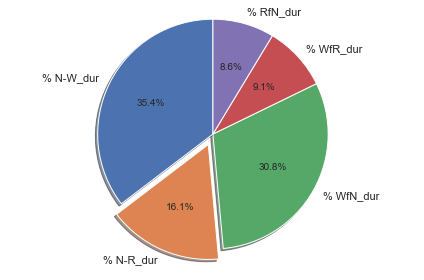

In [70]:
# Pie chart
# Control: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [control_pre_light_series['% N-W_dur']*100,control_pre_light_series['% N-R_dur']*100,control_pre_light_series['% WfN_dur']*100,control_pre_light_series['% WfR_dur']*100,control_pre_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1, ax1 = plt.subplots()
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [71]:
df_res.head()
df_res.iloc[0]

Mouse ID                 1
N-W_count              411
N-R_count               62
W-N_count              469
N-W_sum              20096
N-R_sum               4133
WfN_count              411
WfR_count               58
WfN_sum              13794
WfR_sum               2020
RfN_count               62
RfN_sum               3080
Trans_sum            43123
Dur_Other               77
% N-W_dur         0.465185
% N-R_dur        0.0956713
% RfN_dur        0.0712963
% WfR_dur        0.0467593
% WfN_dur         0.319306
Trans_count           1004
Phenotype      Susceptible
Condition              pre
Phase                Light
% N-W_count       0.409363
% N-R_count       0.061753
% W-N_count       0.467131
% RfN_count       0.061753
% WfR_count      0.0577689
% WfN_count       0.409363
Name: 0, dtype: object

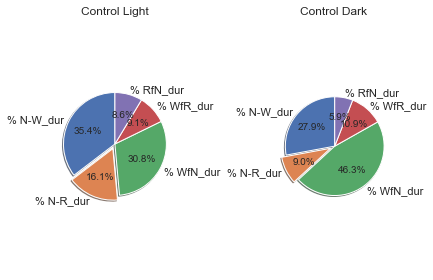

In [72]:
# Pie chart
# Control: L& Dark Pre
# Control: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [control_pre_light_series['% N-W_dur']*100,control_pre_light_series['% N-R_dur']*100,control_pre_light_series['% WfN_dur']*100,control_pre_light_series['% WfR_dur']*100,control_pre_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Control Light')
plt.tight_layout()


#Control: Dark
percent_time = [control_pre_dark_series['% N-W_dur']*100,control_pre_dark_series['% N-R_dur']*100,control_pre_dark_series['% WfN_dur']*100,control_pre_dark_series['% WfR_dur']*100,control_pre_dark_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  

ax2 = fig1.add_subplot(1,2,2)
ax2.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.title('Control Dark')
plt.show()

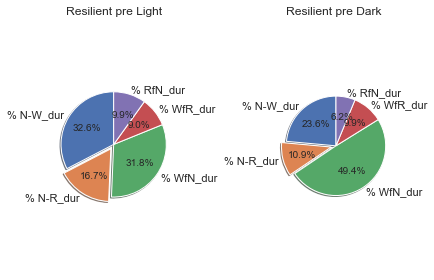

In [73]:
# Pie chart
# Resilient: L& Dark Pre
# Resilient: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [resilient_pre_light_series['% N-W_dur']*100,resilient_pre_light_series['% N-R_dur']*100,resilient_pre_light_series['% WfN_dur']*100,resilient_pre_light_series['% WfR_dur']*100,resilient_pre_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Resilient pre Light')
plt.tight_layout()


#Resilient: Dark
percent_time = [resilient_pre_dark_series['% N-W_dur']*100,resilient_pre_dark_series['% N-R_dur']*100,resilient_pre_dark_series['% WfN_dur']*100,resilient_pre_dark_series['% WfR_dur']*100,resilient_pre_dark_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  

ax2 = fig1.add_subplot(1,2,2)
ax2.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.title('Resilient pre Dark')
plt.show()

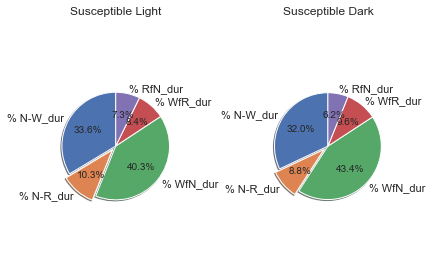

In [74]:
# Pie chart
# Susceptible: L& Dark Pre
# Susceptible: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [susceptible_pre_light_series['% N-W_dur']*100,susceptible_pre_light_series['% N-R_dur']*100,susceptible_pre_light_series['% WfN_dur']*100,susceptible_pre_light_series['% WfR_dur']*100,susceptible_pre_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Susceptible Light')
plt.tight_layout()


#Susceptible: Dark
percent_time = [susceptible_pre_dark_series['% N-W_dur']*100,susceptible_pre_dark_series['% N-R_dur']*100,susceptible_pre_dark_series['% WfN_dur']*100,susceptible_pre_dark_series['% WfR_dur']*100,susceptible_pre_dark_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  

ax2 = fig1.add_subplot(1,2,2)
ax2.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.title('Susceptible Dark')
plt.show()

In [75]:
control_post_light_series = df_res_group.loc['Control'].loc['post'].loc['Light']
control_post_dark_series = df_res_group.loc['Control'].loc['post'].loc['Dark']

resilient_post_light_series = df_res_group.loc['Resilient'].loc['post'].loc['Light']
resilient_post_dark_series = df_res_group.loc['Resilient'].loc['post'].loc['Dark']


susceptible_post_light_series = df_res_group.loc['Susceptible'].loc['post'].loc['Light']
susceptible_post_dark_series = df_res_group.loc['Susceptible'].loc['post'].loc['Dark']

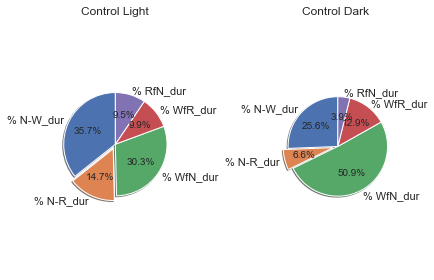

In [76]:
# Pie chart
# Control: L& Dark Post
# Control: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [control_post_light_series['% N-W_dur']*100,control_post_light_series['% N-R_dur']*100,control_post_light_series['% WfN_dur']*100,control_post_light_series['% WfR_dur']*100,control_post_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Control Light')
plt.tight_layout()


#Control: Dark
percent_time = [control_post_dark_series['% N-W_dur']*100,control_post_dark_series['% N-R_dur']*100,control_post_dark_series['% WfN_dur']*100,control_post_dark_series['% WfR_dur']*100,control_post_dark_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  

ax2 = fig1.add_subplot(1,2,2)
ax2.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.title('Control Dark')
plt.show()

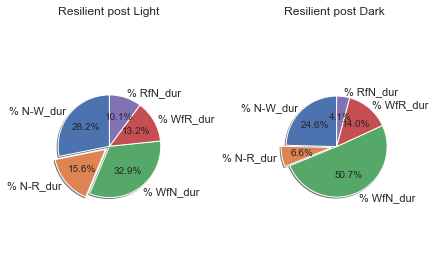

In [77]:
# Pie chart
# Resilient: L& Dark Post
# Resilient: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [resilient_post_light_series['% N-W_dur']*100,resilient_post_light_series['% N-R_dur']*100,resilient_post_light_series['% WfN_dur']*100,resilient_post_light_series['% WfR_dur']*100,resilient_post_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Resilient post Light')
plt.tight_layout()


#Resilient: Dark
percent_time = [resilient_post_dark_series['% N-W_dur']*100,resilient_post_dark_series['% N-R_dur']*100,resilient_post_dark_series['% WfN_dur']*100,resilient_post_dark_series['% WfR_dur']*100,resilient_post_dark_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  

ax2 = fig1.add_subplot(1,2,2)
ax2.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.title('Resilient post Dark')
plt.show()

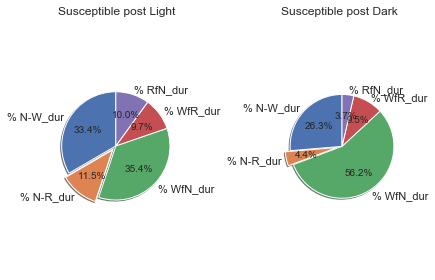

In [78]:
# Pie chart
# Susceptible: L& Dark Post
# Susceptible: Light
states = ['% N-W_dur','% N-R_dur','% WfN_dur','% WfR_dur','% RfN_dur']
percent_time = [susceptible_post_light_series['% N-W_dur']*100,susceptible_post_light_series['% N-R_dur']*100,susceptible_post_light_series['% WfN_dur']*100,susceptible_post_light_series['% WfR_dur']*100,susceptible_post_light_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 2, 1)
ax1.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Susceptible post Light')
plt.tight_layout()


#Susceptible: Dark
percent_time = [susceptible_post_dark_series['% N-W_dur']*100,susceptible_post_dark_series['% N-R_dur']*100,susceptible_post_dark_series['% WfN_dur']*100,susceptible_post_dark_series['% WfR_dur']*100,susceptible_post_dark_series['% RfN_dur']*100 ]


# only "explode" the 2nd slice (i.e. '%N-R_dur')
explode = (0, 0.1, 0, 0,0)  

ax2 = fig1.add_subplot(1,2,2)
ax2.pie(percent_time, explode=explode, labels=states, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal')  
plt.tight_layout()
plt.title('Susceptible post Dark')
plt.show()

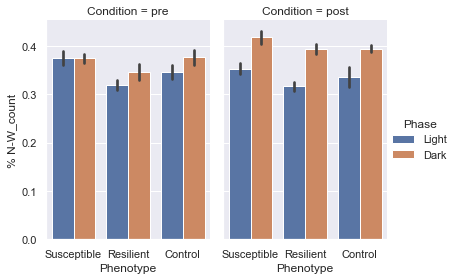

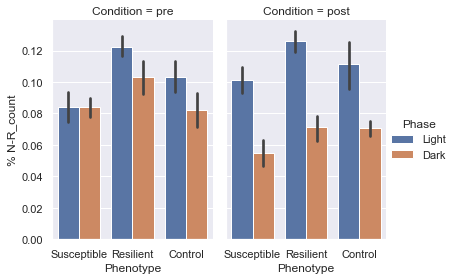

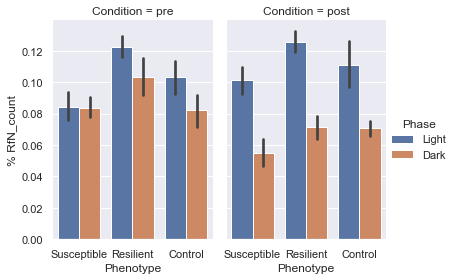

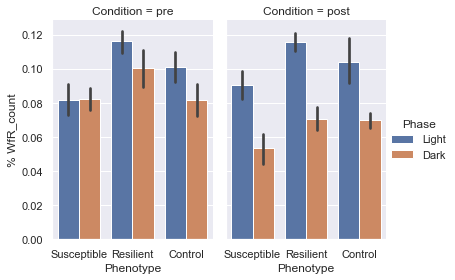

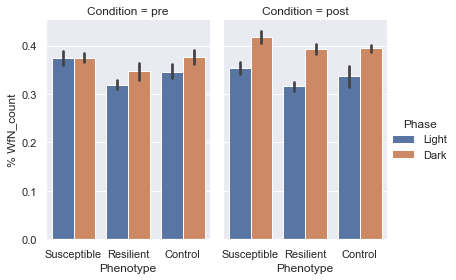

In [79]:
Trans_state =['% N-W_count','% N-R_count','% RfN_count','% WfR_count','% WfN_count']
for trans in Trans_state:
    g = sns.catplot(x='Phenotype',y = trans,
                hue = 'Phase', col = 'Condition',
                data = df_res, kind ="bar",
                height = 4, aspect = .7, ci =68) # standard error ci = 68 .. before it was showing standard deviation
    

# Poisson Distribution of the state transitions counts
TBC

# These findings can be summarized as following:  
- There is an increased competition from the wake circuitry in the suceptible mice pre-and post- exposure to stress. Such heightened competition leads to increased occurrence of shorter "NREM"to wake, "NREM"to REM and "REM"to wake bouts duration. In other words, NREM state and REM state switch 'earlier" to Wake state. Even when NREM switches to REM state, the increased competition from the wake circuitry leads to increased switching from the sleep (NREM then REM) to wake and therefore the sleep (NREM state followed by REM state) switch 'earlier' to Wake state.

- There is an increased competition from the wake circuitry in the resilient mice post exposure to stress during the dark as there is a shift in the distribution of duration of the "NREM"to wake, "NREM"to REM and "REM"to wake bouts to the left.

It is worth mentioning that the distribution of the Wake states, "Wake" from REM and "Wake" from NREM is comparable between the phenotypes. The way 


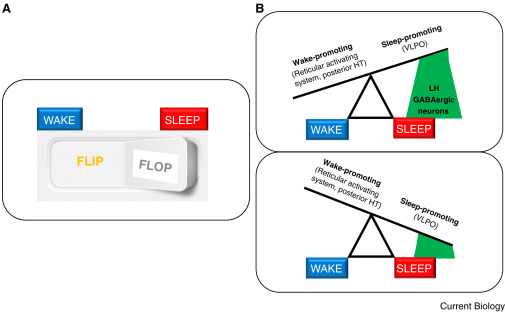

From: https://www.sciencedirect.com/science/article/pii/S096098221630700X

Survival Analysis is then used in order to exploring the "survival" of NREM states and REM state pre- and post-exposure to stress.

# Survival Analysis

In [80]:
# Function to plot Light and Dark Survival Curve Pre and Post exposure to Chronic Stress

def plot_surv_curves(state, direction, transition,measure):

    for condition in ['pre','post']:
        P_l =[]
        E_l = []
        T_l = []
    
        for phase in ['Light','Dark']: 
            P_l = []
            E_l = []
            T_l = []

            for phenotype in ['Susceptible','Resilient','Control']:
                df = load_data(phenotype,phase,condition)    
                df_grouped = grouping_data(df,direction,measure) 
                Dur_l = extract_list(df_grouped,state,transition) 
                events_l = [1]*len(Dur_l)
                phenotype_l = [phenotype]*len(Dur_l)
                T_l.extend(Dur_l)
                E_l.extend(events_l)
                P_l.extend(phenotype_l)
        
                data =  {'Epoch_Duration': T_l,
                         'Events': E_l ,
                         'Phenotype': P_l}
        
            data_df = pd.DataFrame({ key:pd.Series(value) for key, value in data.items() })

            T = data_df['Epoch_Duration']
            E = data_df['Events']
        
            groups = data_df['Phenotype']
            ix1 = (groups == 'Susceptible')
            ix2 = (groups == 'Resilient')
            ix3 = (groups == 'Control')
        
            kmf= KaplanMeierFitter()

            kmf.fit(T[ix1], E[ix1], label='Susceptible')
            ax = plt.subplots()
            ax = kmf.plot()
            #ax.set_yscale('log')
            ax.set_xlim([0,300])
            ax.set_title(condition + phase + transition)

            kmf.fit(T[ix2], E[ix2], label='Resilient')
            ax1 = kmf.plot(ax = ax)

            kmf.fit(T[ix3], E[ix3], label='Control')
            kmf.plot(ax = ax1)


In [81]:
from lifelines.statistics import logrank_test


def compute_logrank(state, direction, phase,condition, transition,measure):
    P_l = []
    E_l = []
    T_l = []

    
    for phenotype in ['Susceptible','Resilient','Control']:
        df = load_data(phenotype,phase,condition)    
        df_grouped = grouping_data(df,direction,measure) 
        Dur_l = extract_list(df_grouped,state,transition) 
        events_l = [1]*len(Dur_l)
        phenotype_l = [phenotype]*len(Dur_l)
        T_l.extend(Dur_l)
        E_l.extend(events_l)
        P_l.extend(phenotype_l)
        
        data =  {'Epoch_Duration': T_l,
                 'Events': E_l ,
                 'Phenotype': P_l}
        
        data_df = pd.DataFrame({ key:pd.Series(value) for key, value in data.items() })

        T = data_df['Epoch_Duration']
        E = data_df['Events']
        
        groups = data_df['Phenotype']
        ix1 = (groups == 'Susceptible')
        ix2 = (groups == 'Resilient')
        ix3 = (groups == 'Control')
        
        
            
    results = logrank_test(T[ix1],T[ix3],E[ix1],E[ix3]) # comparison between S&C
    results1 = logrank_test(T[ix1],T[ix2],E[ix1],E[ix2]) # Comparison between S&R
    results2 = logrank_test(T[ix2],T[ix3],E[ix2],E[ix3]) # Comparison between R&C
            
    return results.print_summary(),results1.print_summary(),results2.print_summary() 

In [82]:
#logrank_test

phase = 'Dark'
condition = 'post'
direction ='From'
state = 'REM'
transition = 'RfN'

compute_logrank(state, direction, phase,condition, transition,measure)

(None, None, None)

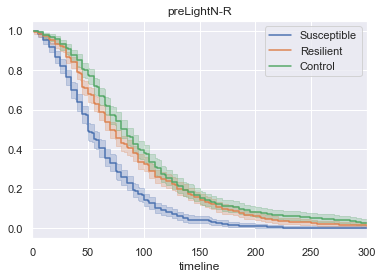

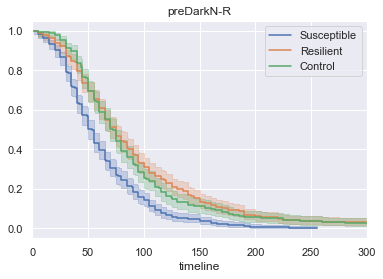

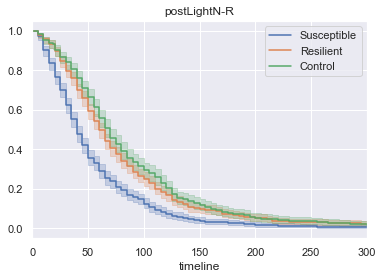

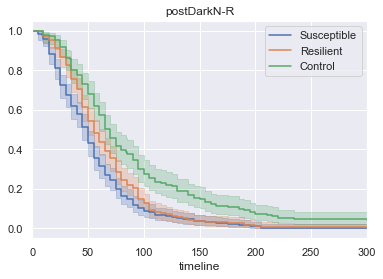

In [83]:
measure = 'Duration'
direction ='To'
state = 'NREM'
transition = 'N-R'

plot_surv_curves(state, direction, transition,measure)


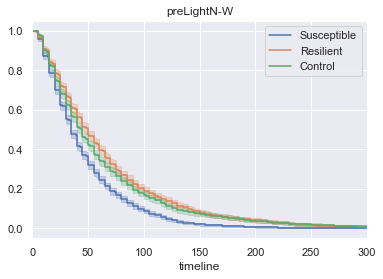

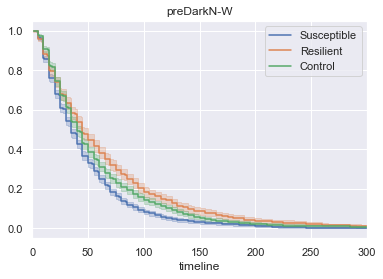

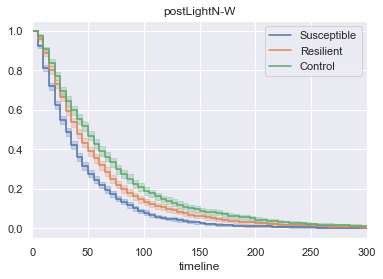

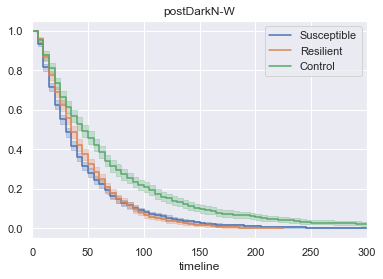

In [84]:
direction ='To'
state = 'NREM'
transition = 'N-W'

plot_surv_curves(state, direction, transition,measure)

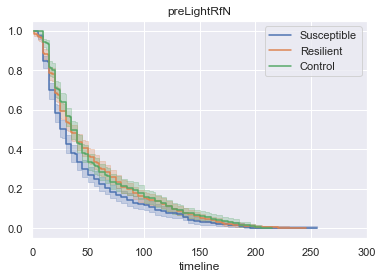

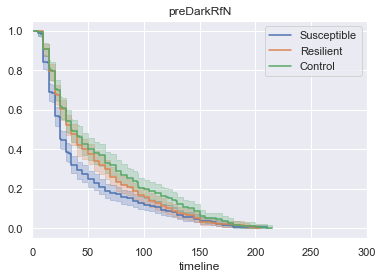

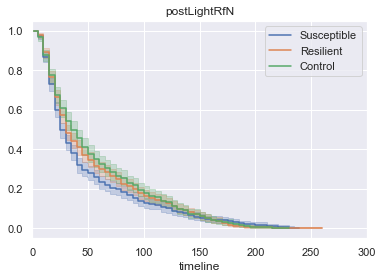

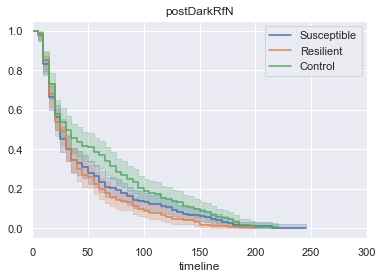

In [85]:
direction ='From'
state = 'REM'
transition = 'RfN'

plot_surv_curves(state, direction, transition,measure)

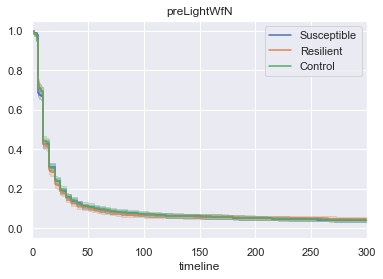

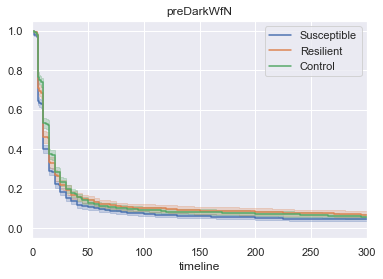

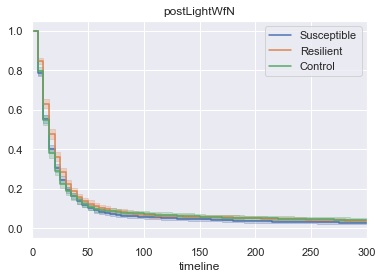

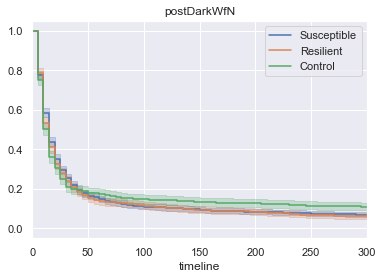

In [86]:
direction ='From'
state = 'Wake'
transition = 'WfN'

plot_surv_curves(state, direction, transition,measure)


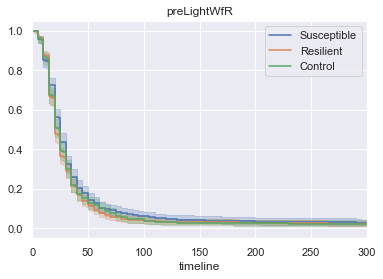

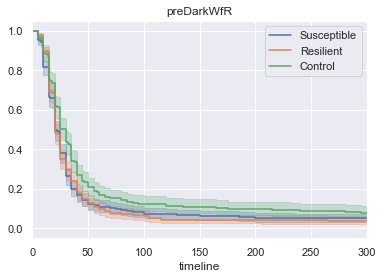

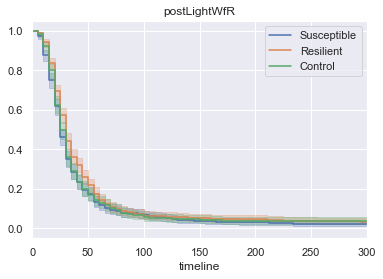

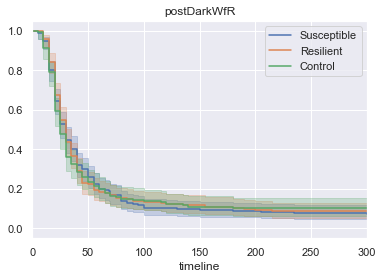

In [87]:
direction ='From'
state = 'Wake'
transition = 'WfR'

plot_surv_curves(state, direction, transition,measure)


# Cox Proportional Hazard Model
To model the impact of covariates on the survival curve

Covariates: 
- condition: pre and post
- phase: light and dark
- Susceptiblity to stress versus Resilience
- Vulnerability to stress


# Markov Model
Aim: To model the sequence of sleep and wake states sequence